# 4. Topic Modelling

+++++++++++++++++++++++++++++++++++++

PART I. BUILD LDA MODEL AND FIND OPTIMAL TOPIC NUMBERS

2021-04-11


+++++++++++++++++++++++++++++++++++++

Contact: yangjx@smail.nju.edu.cn

In [1]:
import numpy as np
import pandas as pd

import os
import re
import spacy
import string
import itertools
from pprint import pprint
from tqdm.notebook import tqdm

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.wrappers import LdaMallet

# NLTK
import nltk
from nltk import bigrams
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from collections import Counter
import collections

import matplotlib.pyplot as plt

import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

ModuleNotFoundError: No module named 'spacy'

In [2]:
# # filter against and favor tweets

# os.chdir(r'D:\twarc\climatetweetID\content_analysis\Data\RawData')
# tweetdf = pd.read_csv("tweetsDF.csv")
# tweetdf = tweetdf[(tweetdf.tweet_type != 'retweet') & (tweetdf.tweet_type != 'quote')]
# tweetdf = tweetdf[tweetdf.prediction == 'AGAINST']
# tweetdf = tweetdf[['Tweet', "datetime", "retweet_count", "final_location", "type_local", "final_lat", "final_lon", "user_id_str"]]
# os.chdir(r'D:\DL_tweets_Classification\4_Topic_modelling\Data\Against')
# tweetdf.to_csv("tweetdf_against.csv", index= False)

# os.chdir(r'D:\twarc\climatetweetID\content_analysis\Data\RawData')
# tweetdf = pd.read_csv("tweetsDF.csv")
# tweetdf = tweetdf[tweetdf.prediction == 'AGAINST']
# tweetdf = tweetdf[['Tweet', "datetime", "retweet_count", "final_location", "type_local", "final_lat", "final_lon", "user_id_str"]]
# os.chdir(r'D:\DL_tweets_Classification\4_Topic_modelling\Data\Against')
# tweetdf.to_csv("tweetdf_against_full.csv", index= False)


os.chdir(r'E:\twarc\climatetweetID\content_analysis\Data\RawData')
tweetdf = pd.read_csv("tweetsDF.csv")
tweetdf = tweetdf[(tweetdf.tweet_type != 'retweet') & (tweetdf.tweet_type != 'quote')]
tweetdf = tweetdf[tweetdf.prediction == 'FAVOR']
tweetdf = tweetdf[['Tweet', "datetime", "retweet_count", "final_location", "type_local", "final_lat", "final_lon", "user_id_str"]]
os.chdir(r'D:\DL_tweets_Classification\4_Topic_modelling\Data\Favor')
tweetdf.to_csv("tweetdf_favor.csv", index= False)

In [2]:
os.chdir(r'E:\twarc\climatetweetID\content_analysis\Data\RawData')
tweetdf = pd.read_csv("tweetsDF.csv")

In [3]:
tweetdf

,Unnamed: 0,Tweet,tweet_type,datetime,final_location,type_local,final_lat,final_lon,id_str,user_id_str,...,favourites_count,followers_count,quote_id_str,retweet_id_str,in_reply_to_status_id_str,retweet_count,favorite_count,prediction,against%,favor%
0,0,#Alaska's #NorthSlope hit by strongest #quake ...,original,2018-08-13,medford or,local_add,42.326418,-122.871860,1028954742255321088,26202000,...,6585,4821,NaN,NaN,NaN,0,0,FAVOR,0.000225,0.999775
1,1,"In the latest edition of The Ripon Forum, @Col...",original,2018-08-13,washington dc,local_add,38.894992,-77.036558,1028954314998509570,18981785,...,544,8949,NaN,NaN,NaN,5,8,FAVOR,0.000032,0.999968
2,2,@GeneMcVay Help save the Sasquatch and nip glo...,reply,2018-08-13,arkansas,state_add,33.981735,-91.557800,1028954321864601600,215672860,...,8162,8159,NaN,NaN,1.027747e+18,6,6,FAVOR,0.017161,0.982839
3,3,The scene in Jurassic Park when Newman loses h...,retweet,2018-08-13,syracuse ny,local_add,43.048122,-76.147424,1028954309919158272,13886002,...,12736,521,NaN,1.028467e+18,NaN,8468,0,FAVOR,0.001039,0.998961
4,4,"Facing $17 Billion in Fire Damages, a CEO Blam...",original,2018-08-13,san francisco ca,local_add,37.779026,-122.419906,1028954334380220417,19894935,...,60921,6591,NaN,NaN,NaN,0,0,FAVOR,0.000075,0.999925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6701726,703067,E.P.A. Cancels Talk on Climate Change by Agenc...,original,2017-10-23,fairfax ca,local_add,37.987293,-122.587967,922515505155424260,996041420,...,7907,690,NaN,NaN,NaN,0,0,FAVOR,0.000192,0.999808
6701727,703068,@ClimateMuseum @austmus @melbournemuseum @nma ...,reply,2017-10-23,redwood city ca,local_add,37.486324,-122.232523,922515315262713857,16014697,...,16377,1566,NaN,NaN,9.221972e+17,0,3,FAVOR,0.000320,0.999680
6701728,703069,EPA abruptly cancels 3 agency scientists' talk...,retweet,2017-10-23,salt lake city ut,local_add,40.759620,-111.886798,922515707169882112,3010783237,...,10767,77,NaN,9.224578e+17,NaN,166,0,FAVOR,0.000027,0.999973
6701729,703070,"Working with satellite data, scientists detect...",original,2017-10-23,phoenix arizona,local_add,33.448437,-112.074142,922515714359017472,28585356,...,14816,8690,NaN,NaN,NaN,5,5,FAVOR,0.001799,0.998201


In [3]:
os.chdir(r'D:\DL_tweets_Classification\4_Topic_modelling\Data\Favor')
tweetdf = pd.read_csv("tweetdf_favor.csv")
tweetdf.dropna(axis=0, how='any', inplace=True)

### Step.1 Tweet text preprocessing

* remove line breaks
* remove URL
* remove numbers
* remove handles (@users)
* remove hashtags (#topics)
* lower capital letters and remove punctuation

In [4]:
def tweet_preprocessor(tweet):

    tweet = tweet.replace('\n', ' ') # remove line breaks
    tweet = re.sub(r"\bhttps://t.co/\w+", '', tweet) # remove URL's
    tweet = re.sub('\w*\d\w*', ' ', tweet) # remove numbers      
    
    r = re.findall("@[\w]* ", tweet) # Remove twitter handles (@users)
    for i in r:
        tweet = re.sub(i, '', tweet)
        
    r = re.findall("#[\w]*", tweet) # Remove twitter hashtages
    for i in r:
        tweet = re.sub(i, '', tweet)
        
    r = re.findall("'s", tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)    
    
    r = re.findall("won't", tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)
    
    r = re.findall("don't", tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)
        
    r = re.findall("doesn't", tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)
    
    r = re.findall("didn't", tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)
    
    r = re.findall("isn't", tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)
    
    r = re.findall("'re", tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)
        
    r = re.findall("'m", tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)  
            
    r = re.findall("lol", tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)

    tweet = re.sub('[%s]' % re.escape(string.punctuation), '', tweet.lower()) # lower capital letters and remove punctuation 
    return tweet

In [5]:
preprocessed_tweet = []
for index, values in tqdm(tweetdf['Tweet'].iteritems()):
    preprocessed = tweet_preprocessor(values)    
    preprocessed_tweet.append(preprocessed)
tweetdf.insert(1, column = 'preprocessed_text', value = preprocessed_tweet)

0it [00:00, ?it/s]

### Step.2 Tokenization

In [6]:
#tweetdf = tweetdf.drop_duplicates(subset=['preprocessed_text'], keep='first', inplace=False)
tweetdf = tweetdf.reset_index()
def tokenize(tweet):
    for word in tweet:
        yield(gensim.utils.simple_preprocess(str(word), deacc=True))  # deacc=True Removes punctuations
        
tweetdf['tidy_tweet_tokens'] = list(tokenize(tweetdf['preprocessed_text']))

### Step.3 Remove stopwords

In [7]:
# Prepare Stop Words
#nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['from', 'https', 'twitter', 'twitt', 'climate change', 'global warming',
                   'climate', 'change', 'global', 'warming', 'instagram', 'lol','good','bad',
                   'people', 'thing', 'news', 'tweet'])
def remove_stopwords(tweets):
    return [[word for word in simple_preprocess(str(tweet)) if word not in stop_words] for tweet in tweets]
tweetdf['tokens_no_stop'] = remove_stopwords(tweetdf['tidy_tweet_tokens'])

In [8]:
# Join the tweet back together
def rejoin_words(row):
    words = row['tokens_no_stop']
    joined_words = (" ".join(words))
    return joined_words
tweetdf['no_stop_joined'] = tweetdf.apply(rejoin_words, axis=1)

### Step.4 Make bigrams

In [9]:
data = tweetdf.no_stop_joined.values.tolist()

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

# Make Bigrams 
# Build the bigram model
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)

# Faster way to get a sentence clubbed as a bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [10]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

# Form Bigrams
data_words_bigrams = make_bigrams(data_words)

### Step.5 Make bigrams

In [11]:
def lemmatization(tweets, allowed_postags):    
    tweets_out = []
    for sent in tweets:
        doc = nlp(" ".join(sent)) 
        tweets_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return tweets_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en_core_web_sm
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [12]:
# Do lemmatization keeping only noun
tweetdf = tweetdf.reset_index()
tweetdf['lemmatized'] = pd.Series(lemmatization(data_words_bigrams, allowed_postags=['NOUN',"ADJ"]))
tweetdf.to_pickle('lemmatized.pkl')

In [13]:
# Remove very short tweets
tweetdf['length'] = tweetdf['lemmatized'].apply(len)
tweetdf = tweetdf.drop(tweetdf[tweetdf['length'] < 5].index)
tweetdf = tweetdf.drop(['length'], axis=1)

tweetdf.reset_index(drop=True, inplace=True)

### Step.6 Dropping duplicates and stemming

In [14]:
# Join the tweet back together
def rejoin_words(row):
    words = row['lemmatized']
    joined_words = (" ".join(words))
    return joined_words

In [15]:
tweetdf['lemmatized_joined'] = tweetdf.apply(rejoin_words, axis=1)
tweetdf = tweetdf.drop_duplicates(subset=['lemmatized_joined'], keep='first', inplace=False)
tweetdf.shape
tweetdf.reset_index(drop=True, inplace=True)

In [16]:
stemmer = PorterStemmer()
tweetdf['stemmed'] = tweetdf['lemmatized']#.apply(lambda x : [stemmer.stem(y) for y in x])

### Step.7 Create Dictionary and Corpus

In [17]:
# Create Dictionary
id2word_stemmed = corpora.Dictionary(tweetdf['stemmed'])
# Create Corpus
tweets_stemmed = tweetdf['stemmed']
corpus_stemmed = [id2word_stemmed.doc2bow(tweet) for tweet in tweets_stemmed]

### Step.8 Find the optimal number of topics

In [18]:
# # https://www.youtube.com/watch?v=zVzUotS9GpQ
# # Tutorial to use mallet wrapper

os.environ['MALLET_HOME'] = 'C:\\mallet'
mallet_path = 'C:\\mallet\\bin\\mallet'
# num_topics = 8
# ldamallet_stemmed = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus_stemmed, num_topics=num_topics, id2word=id2word_stemmed)

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus_stemmed, num_topics=num_topics, id2word=id2word_stemmed)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [19]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word_stemmed, corpus=corpus_stemmed, texts=tweetdf['stemmed'], start=2, limit=15, step=1)

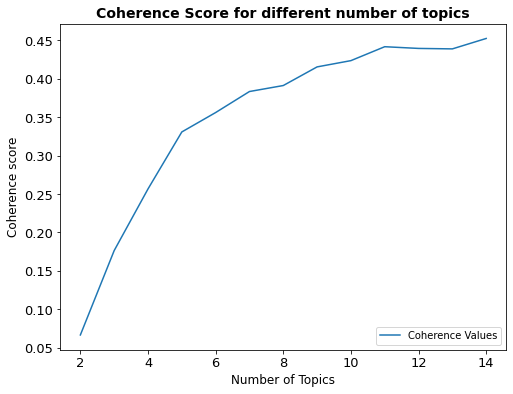

In [20]:
limit=15; start=2; step=1;
x = range(start, limit, step)
plt.figure(figsize=(8,6))
plt.plot(x, coherence_values)
plt.title('Coherence Score for different number of topics', fontsize=14, fontweight="bold")
plt.xlabel("Number of Topics", fontsize=12)
plt.ylabel("Coherence score", fontsize=12)
plt.tick_params(axis='both', labelsize=13)
plt.legend(["Coherence Values"], loc='lower right')
plt.show()

In [21]:
# Print the coherence scores for different number of topics
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.0667
Num Topics = 3  has Coherence Value of 0.1765
Num Topics = 4  has Coherence Value of 0.2566
Num Topics = 5  has Coherence Value of 0.3307
Num Topics = 6  has Coherence Value of 0.3559
Num Topics = 7  has Coherence Value of 0.3832
Num Topics = 8  has Coherence Value of 0.391
Num Topics = 9  has Coherence Value of 0.4153
Num Topics = 10  has Coherence Value of 0.4234
Num Topics = 11  has Coherence Value of 0.4415
Num Topics = 12  has Coherence Value of 0.4393
Num Topics = 13  has Coherence Value of 0.4387
Num Topics = 14  has Coherence Value of 0.4522


In [22]:
optimal_model = model_list[4]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=20))

[(0,
  '0.024*"day" + 0.023*"today" + 0.020*"great" + 0.013*"work" + '
  '0.012*"article" + 0.012*"talk" + 0.011*"story" + 0.011*"week" + '
  '0.011*"research" + 0.008*"late" + 0.007*"student" + 0.006*"school" + '
  '0.006*"hope" + 0.006*"expert" + 0.005*"video" + 0.005*"report" + '
  '0.005*"free" + 0.005*"climatechange" + 0.005*"book" + 0.005*"group"'),
 (1,
  '0.043*"world" + 0.025*"impact" + 0.025*"action" + 0.019*"future" + '
  '0.018*"problem" + 0.015*"solution" + 0.015*"environmental" + '
  '0.014*"community" + 0.013*"health" + 0.013*"part" + 0.012*"risk" + '
  '0.012*"report" + 0.011*"leader" + 0.011*"food" + 0.011*"water" + '
  '0.010*"important" + 0.010*"address" + 0.009*"economic" + '
  '0.009*"environment" + 0.008*"crisis"'),
 (2,
  '0.044*"year" + 0.020*"weather" + 0.013*"due" + 0.013*"study" + '
  '0.012*"extreme" + 0.012*"bad" + 0.012*"high" + 0.012*"effect" + '
  '0.012*"fire" + 0.012*"water" + 0.011*"temperature" + 0.009*"hurricane" + '
  '0.009*"ocean" + 0.008*"record

### Step.9 Assign every tweets to one of the topic

In [23]:
import pickle
with open("modellist_final_full.txt", "wb") as fp:   #Pickling
    pickle.dump(model_list, fp)
with open("cohere_final_full.txt", "wb") as fp:   #Pickling
     pickle.dump(coherence_values, fp)

In [24]:
# os.chdir(r'D:\DL_tweets_Classification\4_Topic_modelling\Data\Against')
# tweetdf = pd.read_csv("tweetdf_against_full.csv")
# tweetdf.dropna(axis=0, how='any', inplace=True)

In [25]:
num_topics = 4
os.environ['MALLET_HOME'] = 'C:\\mallet'
mallet_path = 'C:\\mallet\\bin\\mallet'
#ldamallet_stemmed = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus_stemmed, num_topics=num_topics, id2word=id2word_stemmed)

def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each documen
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    return(sent_topics_df)

In [26]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, 
                                                  corpus=corpus_stemmed, 
                                                  texts=tweetdf['stemmed'])

In [27]:
df_dominant_topic = pd.concat([df_topic_sents_keywords, tweetdf], axis = 1)
df_dominant_topic = df_dominant_topic[["Dominant_Topic", "Perc_Contribution", "Topic_Keywords", "Tweet", "datetime", "retweet_count",
                  "final_location", "type_local", "final_lat", "final_lon","user_id_str"]]
df_dominant_topic.to_csv('dominant_topic_4.csv', index = False)